# IA Project - Face Recognition with Dynamic Triplet Loss

References: https://openaccess.thecvf.com/content_ICCV_2019/papers/Zhang_Learning_Local_Descriptors_With_a_CDF-Based_Dynamic_Soft_Margin_ICCV_2019_paper.pdf

Dataset: http://vis-www.cs.umass.edu/lfw/#download

In [2]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import os

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cpu


### Pre-precessing data

In [4]:
current_path = os.getcwd()

#path to datasets
data_path = current_path + "//lfw"
train_path = current_path + "//data//train_pairs.txt"
test_path = current_path + "//data//test_pairs.txt"
people_path = current_path + "//data//people.txt"

In [5]:
# loading dataset
# dataset = datasets.ImageFolder(data_path, transform = transform)
dataset = datasets.ImageFolder(data_path)
print(f"num samples: {len(dataset)}")

num samples: 13233


In [ ]:
dataset[8][0]

In [58]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

transform = T.Compose([
    T.Resize(250),  # make 250x250
    T.CenterCrop(150),   # then take 150x150 center crop
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

In [15]:
with open(people_path, 'r') as file:
  people_file = file.read()

people_list = people_file.split("\n")
people_list

['AJ_Cook\t1',
 'AJ_Lamas\t1',
 'Aaron_Eckhart\t1',
 'Aaron_Guiel\t1',
 'Aaron_Patterson\t1',
 'Aaron_Peirsol\t4',
 'Aaron_Pena\t1',
 'Aaron_Sorkin\t2',
 'Aaron_Tippin\t1',
 'Abba_Eban\t1',
 'Abbas_Kiarostami\t1',
 'Abdel_Aziz_Al-Hakim\t1',
 'Abdel_Madi_Shabneh\t1',
 'Abdel_Nasser_Assidi\t2',
 'Abdoulaye_Wade\t4',
 'Abdul_Majeed_Shobokshi\t1',
 'Abdul_Rahman\t1',
 'Abdulaziz_Kamilov\t1',
 'Abdullah\t4',
 'Abdullah_Ahmad_Badawi\t1',
 'Abdullah_Gul\t19',
 'Abdullah_Nasseef\t1',
 'Abdullah_al-Attiyah\t3',
 'Abdullatif_Sener\t2',
 'Abel_Aguilar\t1',
 'Abel_Pacheco\t4',
 'Abid_Hamid_Mahmud_Al-Tikriti\t3',
 'Abner_Martinez\t1',
 'Abraham_Foxman\t1',
 'Aby_Har-Even\t1',
 'Adam_Ant\t1',
 'Adam_Freier\t1',
 'Adam_Herbert\t1',
 'Adam_Kennedy\t1',
 'Adam_Mair\t1',
 'Adam_Rich\t1',
 'Adam_Sandler\t4',
 'Adam_Scott\t2',
 'Adel_Al-Jubeir\t3',
 'Adelina_Avila\t1',
 'Adisai_Bodharamik\t1',
 'Adolfo_Aguilar_Zinser\t3',
 'Adolfo_Rodriguez_Saa\t2',
 'Adoor_Gopalakarishnan\t1',
 'Adrian_Annus\t1',
 'Adria

In [25]:
# vocab
label_name = {i: people_list[i].split()[0] for i in range(len(people_list))}
name_label = {people_list[i].split()[0]: i for i in range(len(people_list))}

{'AJ_Cook': 0,
 'AJ_Lamas': 1,
 'Aaron_Eckhart': 2,
 'Aaron_Guiel': 3,
 'Aaron_Patterson': 4,
 'Aaron_Peirsol': 5,
 'Aaron_Pena': 6,
 'Aaron_Sorkin': 7,
 'Aaron_Tippin': 8,
 'Abba_Eban': 9,
 'Abbas_Kiarostami': 10,
 'Abdel_Aziz_Al-Hakim': 11,
 'Abdel_Madi_Shabneh': 12,
 'Abdel_Nasser_Assidi': 13,
 'Abdoulaye_Wade': 14,
 'Abdul_Majeed_Shobokshi': 15,
 'Abdul_Rahman': 16,
 'Abdulaziz_Kamilov': 17,
 'Abdullah': 18,
 'Abdullah_Ahmad_Badawi': 19,
 'Abdullah_Gul': 20,
 'Abdullah_Nasseef': 21,
 'Abdullah_al-Attiyah': 22,
 'Abdullatif_Sener': 23,
 'Abel_Aguilar': 24,
 'Abel_Pacheco': 25,
 'Abid_Hamid_Mahmud_Al-Tikriti': 26,
 'Abner_Martinez': 27,
 'Abraham_Foxman': 28,
 'Aby_Har-Even': 29,
 'Adam_Ant': 30,
 'Adam_Freier': 31,
 'Adam_Herbert': 32,
 'Adam_Kennedy': 33,
 'Adam_Mair': 34,
 'Adam_Rich': 35,
 'Adam_Sandler': 36,
 'Adam_Scott': 37,
 'Adel_Al-Jubeir': 38,
 'Adelina_Avila': 39,
 'Adisai_Bodharamik': 40,
 'Adolfo_Aguilar_Zinser': 41,
 'Adolfo_Rodriguez_Saa': 42,
 'Adoor_Gopalakarishnan'

In [61]:
with open(train_path, 'r') as file:
  train_file = file.read()

train_list = train_file.split("\n")

In [62]:
#ottengo una lista delle persone nel training set
people_train = []
for item in train_list:
    item = item.split()
    people_train.append(item[0])
people_train = list(dict.fromkeys(people_train[1:]))

In [63]:
with open(test_path, 'r') as file:
  test_file = file.read()

test_list = test_file.split("\n")

In [64]:
#ottengo una lista delle persone nel test set
people_test = []
for item in test_list:
    item = item.split()
    people_test.append(item[0])
people_test = list(dict.fromkeys(people_test[1:]))

In [65]:
print(f"Num. training samples: {len(people_train)}")
print(f"Num. test samples: {len(people_test)}")

Num. training samples: 1519
Num. test samples: 696


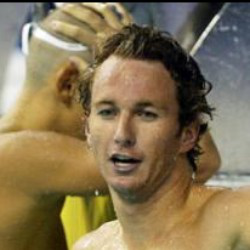